#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Календарные-признаки" data-toc-modified-id="Календарные-признаки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Календарные признаки</a></span></li><li><span><a href="#Отстающие-значения" data-toc-modified-id="Отстающие-значения-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Отстающие значения</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Скользящее среднее</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', decimal = ',', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

In [ ]:
df = df.resample('1H').sum()

## Анализ

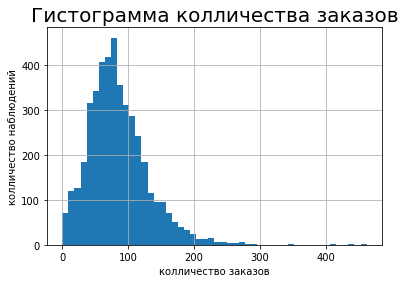

In [ ]:
df.num_orders.hist(bins=50)
plt.title("Гистограмма колличества заказов", fontsize=20)
plt.xlabel('колличество заказов')
plt.ylabel('колличество наблюдений')
plt.show() 

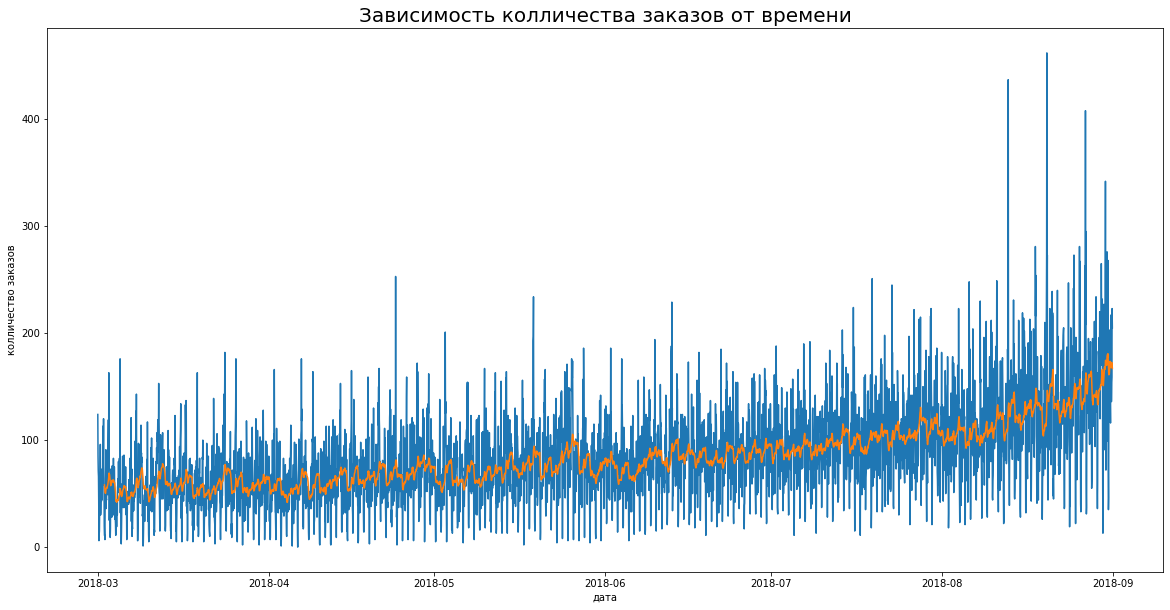

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df.index,df.num_orders)
plt.plot(df.index,df['num_orders'].rolling(30).mean())
plt.title("Зависимость колличества заказов от времени", fontsize=20)
plt.xlabel('дата')
plt.ylabel('колличество заказов')
plt.show() 

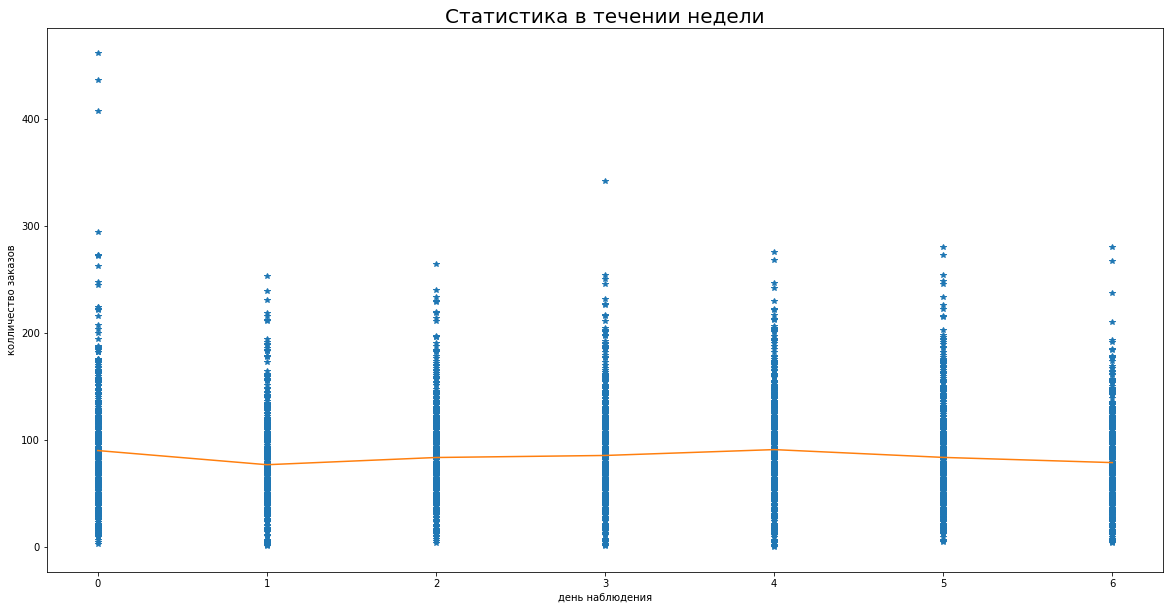

In [ ]:
df['dayofweek'] = df.index.dayofweek
days_num = [0,1,2,3,4,5,6] 
mean_orders = []
for day in days_num:
    mean_orders.append(df[df.dayofweek == day]['num_orders'].mean())
    
plt.figure(figsize=(20, 10))
plt.plot(df.dayofweek,df.num_orders, '*')
plt.plot(days_num,mean_orders)
plt.title("Статистика в течении недели", fontsize=20)
plt.xlabel('день наблюдения')
plt.ylabel('колличество заказов')
plt.show() 

люди заказывают такли независимо от дня недели. Среднее чуть ниже 100 и практически не меняется. Однако в понедельник наблюдается наибольшее колличество выбросов. Все мы любим хорошо отдохнуть в воскресенье))


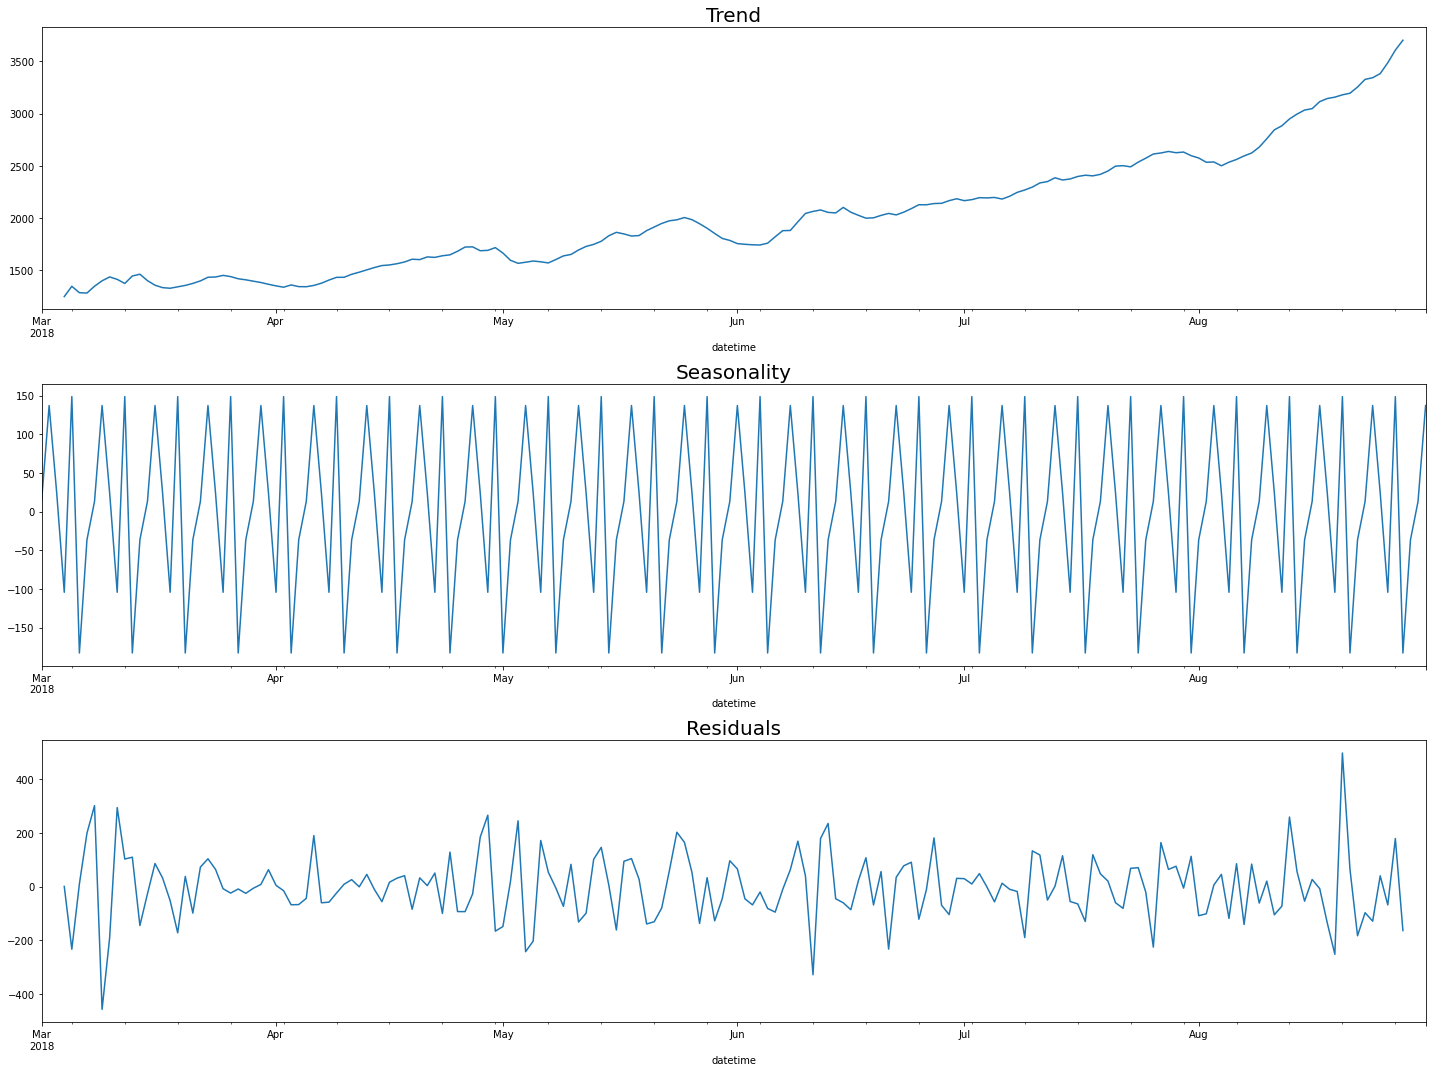

In [ ]:
decomposed = seasonal_decompose(df.num_orders.resample('1D').sum())

plt.figure(figsize=(20, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', fontsize=20)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', fontsize=20)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals', fontsize=20)
plt.tight_layout()

Тренд показывает достаточно стабильный рост числа заказов. Абсолютная периодичность от недели к неделе и большой объем шума


### Календарные признаки

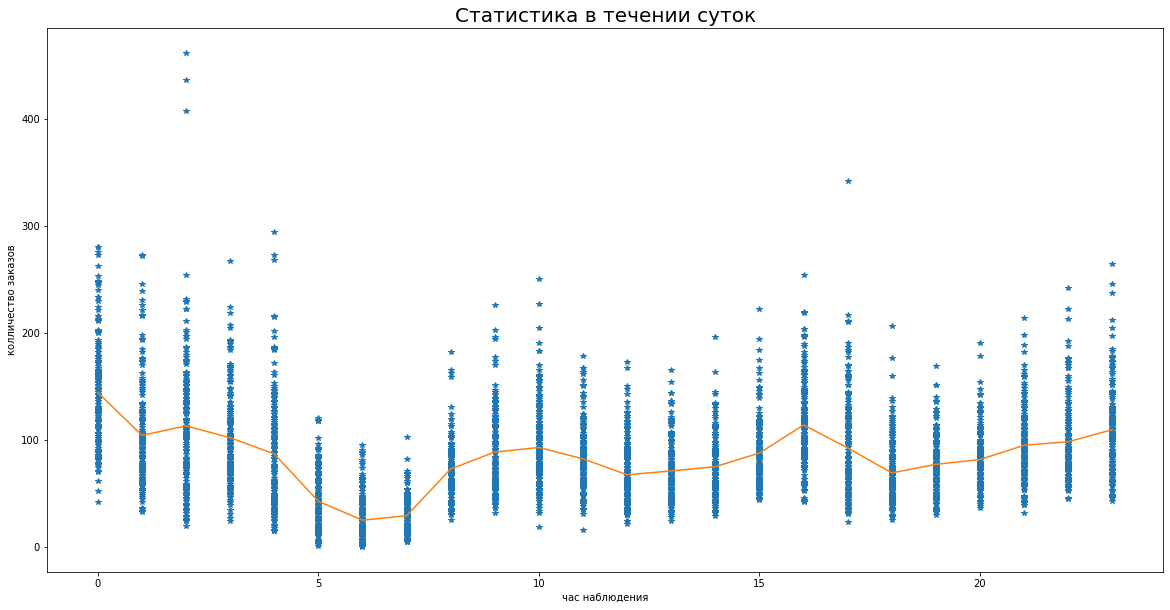

In [ ]:
df['hour'] = df.index.hour
hour_num = range(0,24)
mean_orders_hour = []
for hour in hour_num:
    mean_orders_hour.append(df[df.hour == hour]['num_orders'].mean())

plt.figure(figsize=(20, 10))
plt.plot(df.hour,df.num_orders, '*')
plt.plot(hour_num,mean_orders_hour)
plt.title("Статистика в течении суток", fontsize=20)
plt.xlabel('час наблюдения')
plt.ylabel('колличество заказов')
plt.show() 

А вот с 5 до 8 утра люди не очень любят заказывать такси. Видимо пробки...


### Отстающие значения

In [ ]:
data = df.copy()
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_3'] = data['num_orders'].shift(3)

print(data.head(10)) 

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3
datetime                                                             
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0
2018-03-01 05:00:00           6          3     5   43.0   66.0   71.0
2018-03-01 06:00:00          12          3     6    6.0   43.0   66.0
2018-03-01 07:00:00          15          3     7   12.0    6.0   43.0
2018-03-01 08:00:00          34          3     8   15.0   12.0    6.0
2018-03-01 09:00:00          69          3     9   34.0   15.0   12.0


### Скользящее среднее

In [ ]:
df['rolling_mean'] = df['num_orders'].rolling(5).mean()

print(df.head(10)) 

                     num_orders  dayofweek  hour  rolling_mean
datetime                                                      
2018-03-01 00:00:00         124          3     0           NaN
2018-03-01 01:00:00          85          3     1           NaN
2018-03-01 02:00:00          71          3     2           NaN
2018-03-01 03:00:00          66          3     3           NaN
2018-03-01 04:00:00          43          3     4          77.8
2018-03-01 05:00:00           6          3     5          54.2
2018-03-01 06:00:00          12          3     6          39.6
2018-03-01 07:00:00          15          3     7          28.4
2018-03-01 08:00:00          34          3     8          22.0
2018-03-01 09:00:00          69          3     9          27.2


## Обучение

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(df, 6, 1)
df = df.dropna()

target = df['num_orders']
features = df.drop(['num_orders'] , axis=1)

features_20, features_train, target_20, target_train = train_test_split(
    features, target, test_size=0.8, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_20, target_20, test_size=0.5, random_state=12345)

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
features_valid = scaler.transform(features_valid)

In [ ]:
max_leaves = 0
max_rmse = 0
for leaves in range(11, 50, 1):    # 13
    Forest_model = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = leaves, n_estimators = 1, class_weight = None)
    Forest_model.fit(features_train, target_train)
    if max_rmse < (mean_squared_error(target_test, Forest_model.predict(features_test)))**0.5:
        max_rmse = (mean_squared_error(target_test, Forest_model.predict(features_test)))**0.5
        max_leaves = leaves
    
print('max_leaves =', max_leaves) 
print('max_rmse =', max_rmse)

max_leaves = 13
max_rmse = 43.97993794448419


In [ ]:
max_trees = 0
max_rmse = 0
for trees in range(11, 50, 1):    # 11
    Forest_model = RandomForestRegressor(n_estimators=trees, random_state=999)
    Forest_model.fit(features_train, target_train)
    if max_rmse < (mean_squared_error(target_test, Forest_model.predict(features_test)))**0.5:
        max_rmse = (mean_squared_error(target_test, Forest_model.predict(features_test)))**0.5
        max_trees = trees
print('n_estimators =', max_trees) 
print('max_rmse', max_rmse)  

n_estimators = 11
max_rmse 27.463582180233225


In [ ]:
model_linear = LinearRegression().fit(features_train, target_train)
print("RMSE линейной регрессии: ", (mean_squared_error(model_linear.predict(features_test), target_test))**0.5)

model_gbm = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 13, n_estimators = 1, class_weight = None)
model_gbm.fit(features_train, target_train)
print("RMSE lGBM модели: ", (mean_squared_error(model_gbm.predict(features_test), target_test))**0.5)

model_Forest = RandomForestRegressor(n_estimators=11, random_state=999)
model_Forest.fit(features_train, target_train)
print("RMSE случайного леса: ", (mean_squared_error(model_Forest.predict(features_test), target_test))**0.5)

RMSE линейной регрессии:  33.59957042703257
RMSE lGBM модели:  43.97993794448419
RMSE случайного леса:  27.463582180233225


## Тестирование

In [ ]:
print("RMSE линейной регрессии: ", (mean_squared_error(model_linear.predict(features_valid), target_valid))**0.5)

print("RMSE lGBM модели: ", (mean_squared_error(model_gbm.predict(features_valid), target_valid))**0.5)

print("RMSE случайного леса: ", (mean_squared_error(model_Forest.predict(features_valid), target_valid))**0.5)

RMSE линейной регрессии:  35.211626089588364
RMSE lGBM модели:  42.9361515229356
RMSE случайного леса:  29.748687816920302


Качество моделей не особо высокое, но для разброса от 0 до 400, не самое плохое)). Лучше всех ебя показала модель случайного леса. На валидационной выборке модели сработали незначительно хуже, а значет 10% (около 400 записей) хватило для обучения модели

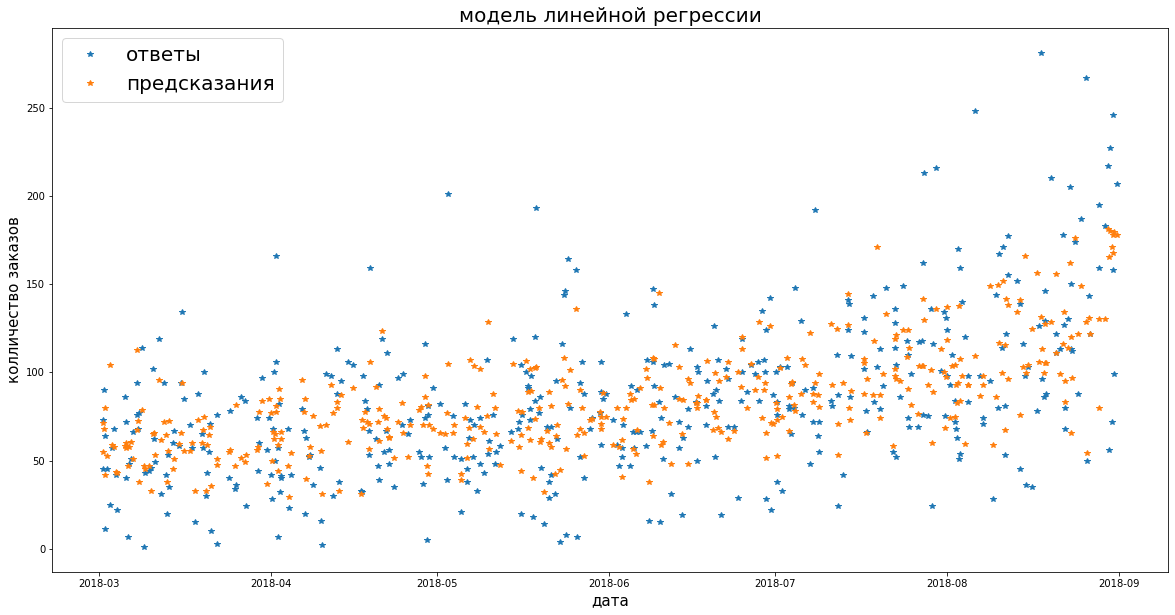

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(target_valid.index,target_valid, '*', label = 'ответы')
plt.plot(target_valid.index,model_linear.predict(features_valid), '*', label = 'предсказания')
plt.legend(fontsize=20)
plt.title("модель линейной регрессии", fontsize=20)
plt.xlabel('дата', fontsize=15)
plt.ylabel('колличество заказов', fontsize=15)
plt.show() 

модель линейной регрессии старается держаться поближе в некотором коридоре около среднего значения в каждом временном промежутке


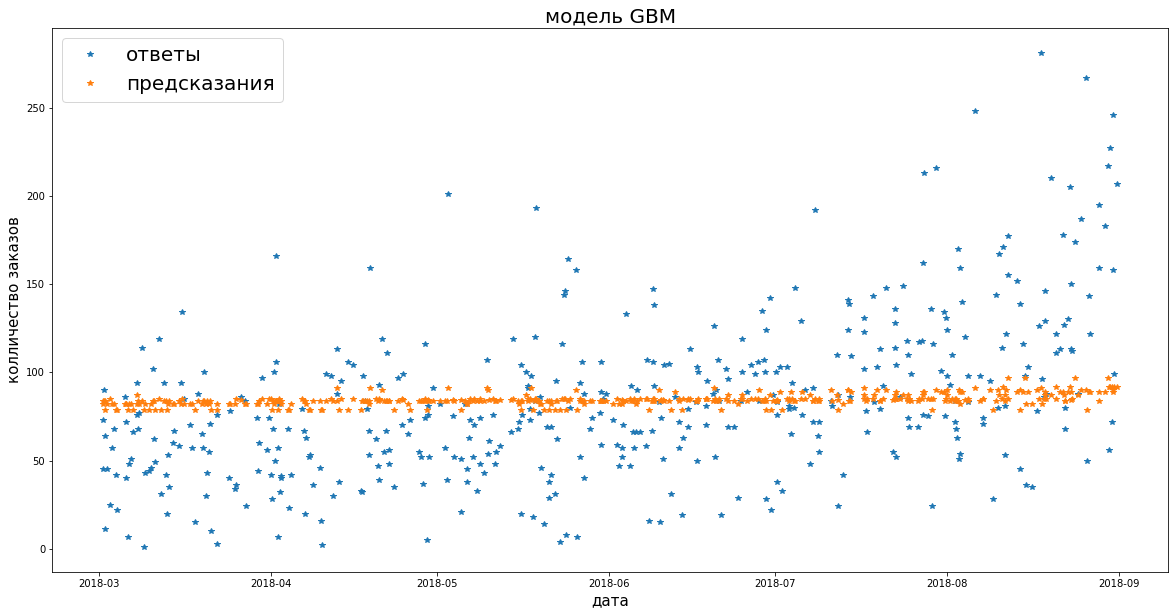

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(target_valid.index,target_valid, '*', label = 'ответы')
plt.plot(target_valid.index,model_gbm.predict(features_valid), '*', label = 'предсказания')
plt.legend(fontsize=20)
plt.title("модель GBM", fontsize=20)
plt.xlabel('дата', fontsize=15)
plt.ylabel('колличество заказов', fontsize=15)
plt.show() 

 модель GBM не отходит от среднего по всей выборке. не удачная стратегия.


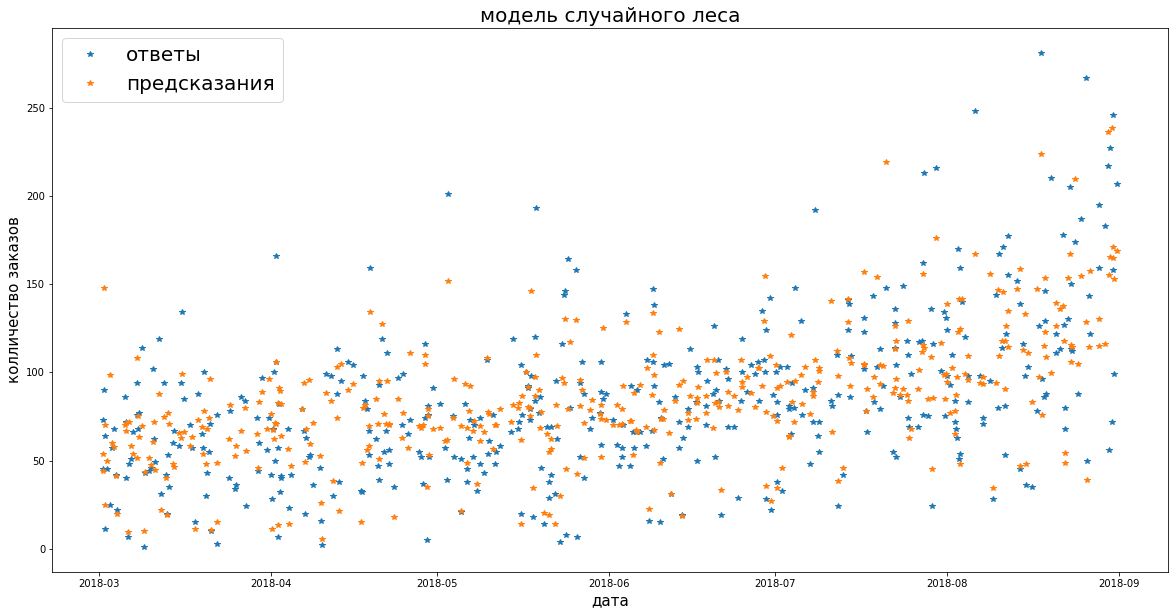

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(target_valid.index,target_valid, '*', label = 'ответы')
plt.plot(target_valid.index,model_Forest.predict(features_valid), '*', label = 'предсказания')
plt.legend(fontsize=20)
plt.title("модель случайного леса", fontsize=20)
plt.xlabel('дата', fontsize=15)
plt.ylabel('колличество заказов', fontsize=15)
plt.show() 

Модель случайного леса "не боится рисковать" и показывает отличный результат. Так же видно, что во многих местах значения и вовсе совпадаю или максимально близки к этому.
